# Dog Breed Classification using CNN

In [3]:
import os
import sys
import numpy as np
import pandas as pd
import sklearn
#import cv2
import time
import json
from IPython.core.display import HTML
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
import keras
import tensorflow as tf
import tensorflow_hub
from tensorflow import keras
from tensorflow.python.keras import backend as k
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import initializers
from tensorflow.keras import regularizers 
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback

from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout
from sklearn.metrics import accuracy_score
#############################
from tensorflow.keras.applications import ResNet50V2, VGG16, InceptionV3, MobileNetV2, DenseNet121
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import xml.etree.ElementTree as ET
from PIL import Image
#import tensorflow_datasets as tfds
#import tensorflow_addons as tfa

In [4]:
#!pip install --upgrade tensorflow_hub

In [5]:
#conda remove tensorflow_hub

In [8]:
# Création de repertoire de stockage d'images
import requests
import tarfile
dataset_path = "Projet_Stanford_Dogs"
if not os.path.exists(dataset_path):
    os.mkdir(dataset_path)

In [9]:
# Télécharge des images sur le site Stanfors
packet_url = "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"
packet_file = os.path.basename(packet_url)
packet_file = os.path.join(dataset_path, packet_file)
with requests.get(packet_url, stream = True) as r:
    r.raise_for_status()
    with open(packet_file, "wb") as f:
        for chunk in r.iter_content(chunk_size = 8192):
            f.write(chunk)
with tarfile.open(packet_file) as tfile:
    tfile.extractall(dataset_path)

#######
packet_url = "http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar"
packet_file = os.path.basename(packet_url)
packet_file = os.path.join(dataset_path, packet_file)
with requests.get(packet_url, stream = True) as r:
    r.raise_for_status()
    with open(packet_file, "wb") as f:
        for chunk in r.iter_content(chunk_size = 8192):
            f.write(chunk)
with tarfile.open(packet_file) as tfile:
    tfile.extractall(dataset_path)

## Importation des données

In [10]:
# On recuperer les races 
print(os.listdir("Projet_Stanford_Dogs/Images/")[:20])
breed_list = os.listdir("Projet_Stanford_Dogs/Images/")

['n02102480-Sussex_spaniel', 'n02097130-giant_schnauzer', 'n02094258-Norwich_terrier', 'n02113023-Pembroke', 'n02105855-Shetland_sheepdog', 'n02094114-Norfolk_terrier', 'n02093428-American_Staffordshire_terrier', 'n02100583-vizsla', 'n02112137-chow', 'n02108915-French_bulldog', 'n02091134-whippet', 'n02088238-basset', 'n02105056-groenendael', 'n02101006-Gordon_setter', 'n02104029-kuvasz', 'n02099849-Chesapeake_Bay_retriever', 'n02097298-Scotch_terrier', 'n02095314-wire-haired_fox_terrier', 'n02087394-Rhodesian_ridgeback', 'n02093859-Kerry_blue_terrier']


In [17]:
# Get the dog labels
# get labels by splitting the folder name at dash
breeds = [breed.split('-',1)[1] for breed in breed_list]
print(len(breeds))
print("\n")

# view same of the labels
breed_selected = breeds[:20]
print("les 20 races sélectionnés :\n\n", breed_selected)

120


les 20 races sélectionnés :

 ['dhole', 'cairn', 'kelpie', 'Shih-Tzu', 'Airedale', 'bull_mastiff', 'Doberman', 'Lakeland_terrier', 'Chihuahua', 'Rhodesian_ridgeback', 'Kerry_blue_terrier', 'Welsh_springer_spaniel', 'Brittany_spaniel', 'giant_schnauzer', 'West_Highland_white_terrier', 'Sealyham_terrier', 'Maltese_dog', 'Norwich_terrier', 'beagle', 'Japanese_spaniel']


Text(0.5, 0.98, 'Quelques Images de Chiens')

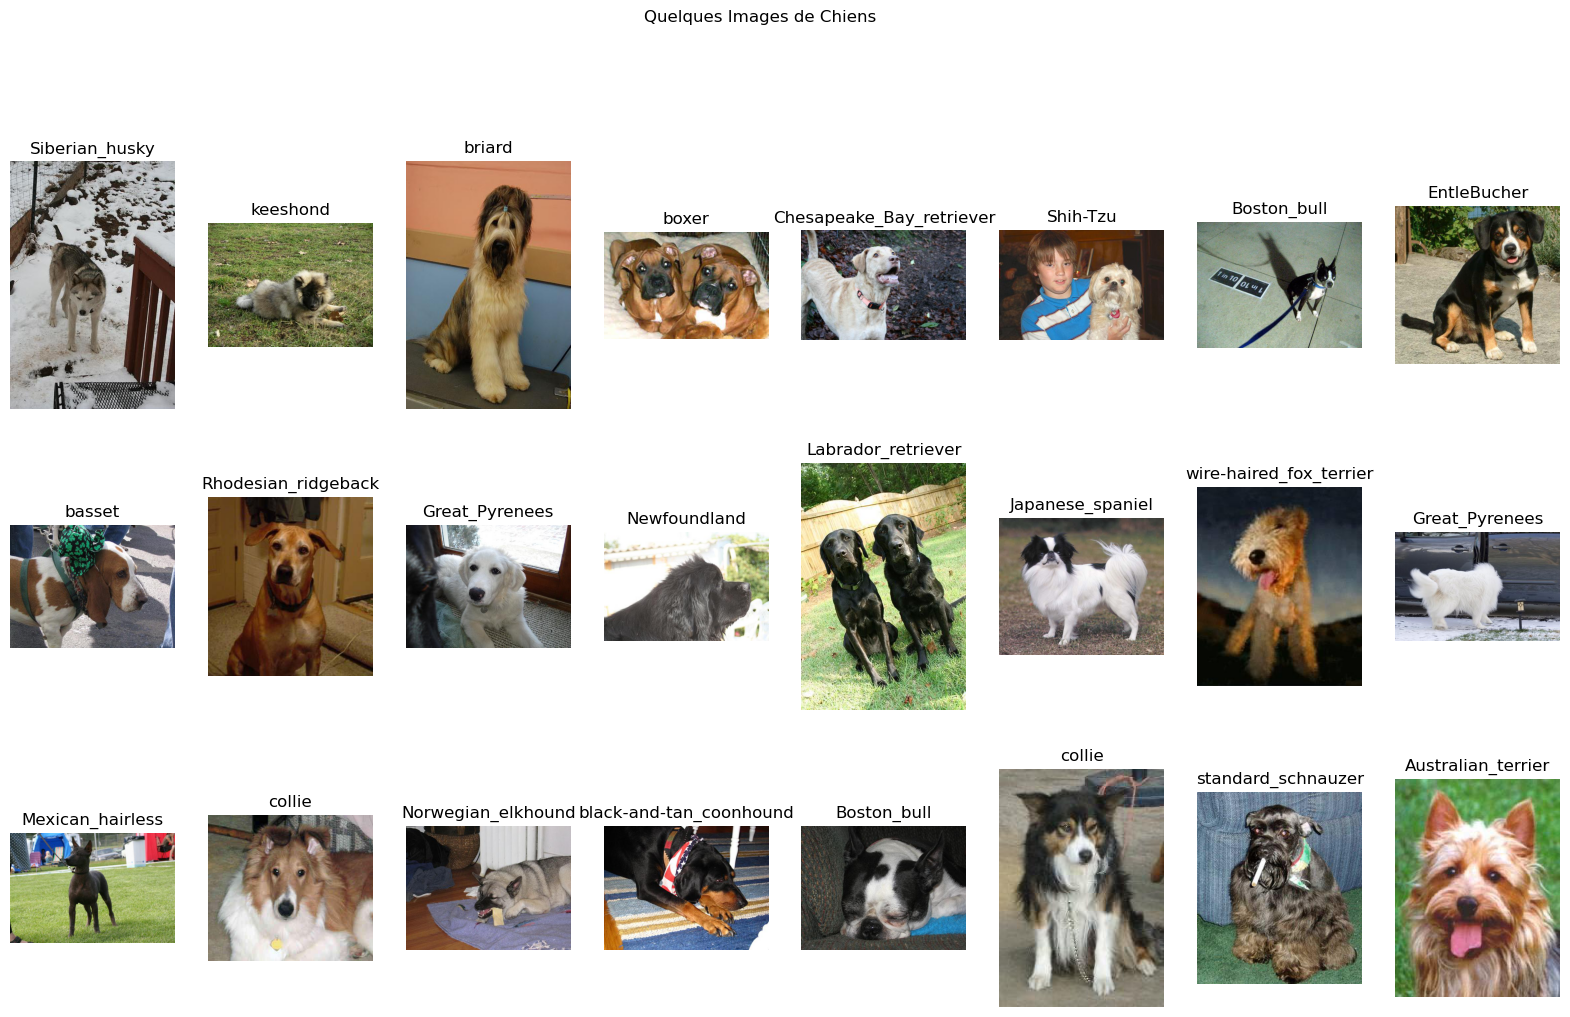

In [18]:
#  Train images
fig = plt.figure(figsize=(20, 15))
for i in range(24):
    axs = fig.add_subplot(4,8,i+1)
    breed = np.random.choice(breed_list)
    dog = np.random.choice(os.listdir("Projet_Stanford_Dogs/Annotation/" + breed))
    img = Image.open("Projet_Stanford_Dogs/Images/" + breed + "/" + dog + ".jpg")
    tree = ET.parse("Projet_Stanford_Dogs/Annotation/" + breed +"/" + dog)
    root = tree.getroot()
    object_1 = root = tree.findall("object")[0];
    name = object_1.find("name").text;
    axs.set_title(name)
    plt.imshow(img)
    plt.axis("off")
    
plt.suptitle("Quelques Images de Chiens")

In [19]:
breed_list.sort()

## Création label index

label2index = dict((name, index) for index, name in enumerate(breed_list))

index2label = dict(( index, name) for index, name in enumerate(breed_list))

images = []

annotations = []

for breed in breed_list:
    
    image_files = os.listdir("Projet_Stanford_Dogs/Images/" + breed)
    
    image_files.sort()
    
    images.extend([os.path.join("Projet_Stanford_Dogs/Images/" + breed, f) for f in image_files])
    
    annotations.extend([os.path.join("Projet_Stanford_Dogs/Annotations/", breed, f.replace(".jpg", "")) for f in image_files])

    
for idx, ann in enumerate(annotations):
    
    annotations[idx] = ann.split("/")[2]
    

## Data Train & Label

In [20]:
Xs = np.asarray(images)

Ys = np.asarray(annotations)

print("Xs shape", Xs.shape)

print(Xs[:5])
print("\n")
print("Ys shape", Ys.shape)

print(Ys[:5])


Xs shape (20580,)
['Projet_Stanford_Dogs/Images/n02085620-Chihuahua/n02085620_10074.jpg'
 'Projet_Stanford_Dogs/Images/n02085620-Chihuahua/n02085620_10131.jpg'
 'Projet_Stanford_Dogs/Images/n02085620-Chihuahua/n02085620_10621.jpg'
 'Projet_Stanford_Dogs/Images/n02085620-Chihuahua/n02085620_1073.jpg'
 'Projet_Stanford_Dogs/Images/n02085620-Chihuahua/n02085620_10976.jpg']


Ys shape (20580,)
['n02085620-Chihuahua' 'n02085620-Chihuahua' 'n02085620-Chihuahua'
 'n02085620-Chihuahua' 'n02085620-Chihuahua']


## Choix du sous-ensemble pour teste du code

In [21]:
X = Xs[:1000]

y = Ys[:1000]

## Conversion de label en numérique

In [22]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

In [23]:
# Label and one-hot encoding y labels
le = LabelEncoder()
le.fit(y)
y_target = to_categorical(le.transform(y), len(breed_selected))
print(y_target.shape)
y_target = np.array(y_target)

(1000, 20)


## Repartition de dataset en train data + test data

In [24]:
from keras.preprocessing.image import img_to_array, load_img

In [25]:
# load, resize images and store as array
images = np.array([img_to_array(load_img(img, target_size = (299,299))) for img in X]) 

x_train, x_test, y_train, y_test = train_test_split(images, y_target, test_size = 0.3,stratify = np.array(y), random_state = 120) 

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,test_size = 0.3,stratify=np.array(y_train),random_state = 120)

print('Training Dataset Size: ', x_train.shape)
print("\n")

print('Training Label Size: ', y_train.shape)
print("\n")

print('Validation Dataset Size: ', x_val.shape)
print("\n")

print('Validation Label Size: ', y_val.shape)
print("\n")

print('Testing Dataset Size: ', x_test.shape)
print("\n")

print('Testing Label Size: ', y_test.shape)

import gc
del images
gc.collect()

Training Dataset Size:  (490, 299, 299, 3)


Training Label Size:  (490, 20)


Validation Dataset Size:  (210, 299, 299, 3)


Validation Label Size:  (210, 20)


Testing Dataset Size:  (300, 299, 299, 3)


Testing Label Size:  (300, 20)


0

## Preparation des données & data augmetation

In [26]:
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

In [27]:
batch_size = 32

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 30,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True
)


train_generator = train_datagen.flow(x_train,y_train,shuffle=False,batch_size = batch_size)

In [28]:
val_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

valid_generator = val_datagen.flow(x_val, y_val, shuffle = False, batch_size = batch_size)

In [29]:
test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

test_generator = val_datagen.flow(x_test, y_test, shuffle = False, batch_size = batch_size)

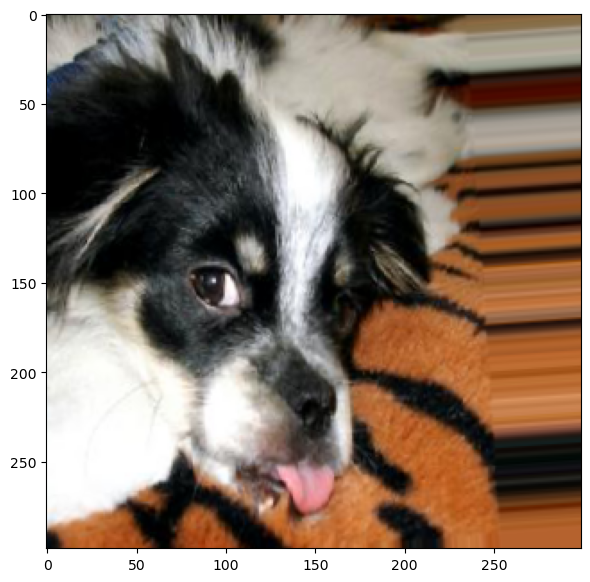

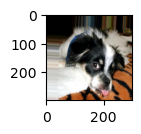

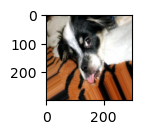

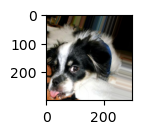

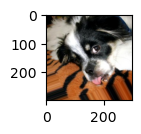

In [30]:
img_id = 8
dog_generator = train_datagen.flow(x_train[img_id:img_id+1], y_train[img_id:img_id+1],
                              shuffle = False, batch_size = batch_size, seed=2)
plt.figure(figsize=(40, 30))
dogs = [next(dog_generator) for i in range(0,5)]
for counter, dog in enumerate(dogs):
    plt.subplot(1, 5, counter+1)
    plt.imshow(dog[0][0])
    plt.show()

# Convolutional Neurl Network 

In [19]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input, concatenate
from keras.layers import Dropout, Flatten, Dense

In [20]:
model_cnn = Sequential()

model_cnn.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(299, 299, 3)))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(Flatten())
model_cnn.add(Dense(512, activation = 'relu'))
model_cnn.add(Dense(20, activation = 'softmax'))

In [21]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 297, 297, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 148, 148, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 73, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 35, 35, 128)       0

In [22]:
model_cnn.compile(loss= 'categorical_crossentropy', optimizer= keras.optimizers.Adam(learning_rate= 1e-3), metrics= ['accuracy'])

In [23]:
start_time_cnn = time.time()

history = model_cnn.fit(

    train_generator,
    
    batch_size = batch_size,
    
    epochs = 20,
    
    validation_data = valid_generator,
        
    verbose = 1, 
    
    shuffle = True)

excution_time_cnn = (time.time() - start_time)/60.0

print('Training time: {:.1f}s'.format(excution_time_cnn))

Epoch 1/20
16/16 [==============================] - 179s 11s/step - loss: 2.2632 - accuracy: 0.1878 - val_loss: 2.2903 - val_accuracy: 0.1476
Epoch 2/20
16/16 [==============================] - 200s 12s/step - loss: 1.7706 - accuracy: 0.2204 - val_loss: 2.0568 - val_accuracy: 0.1476
Epoch 3/20
16/16 [==============================] - 185s 11s/step - loss: 1.7676 - accuracy: 0.2061 - val_loss: 2.1755 - val_accuracy: 0.1667
Epoch 4/20
16/16 [==============================] - 154s 9s/step - loss: 1.7272 - accuracy: 0.2347 - val_loss: 3.3288 - val_accuracy: 0.2286
Epoch 5/20
16/16 [==============================] - 151s 9s/step - loss: 1.6994 - accuracy: 0.2694 - val_loss: 11.0721 - val_accuracy: 0.1762
Epoch 6/20
16/16 [==============================] - 150s 9s/step - loss: 1.7241 - accuracy: 0.2510 - val_loss: 3.0899 - val_accuracy: 0.2429
Epoch 7/20
16/16 [==============================] - 149s 9s/step - loss: 1.6839 - accuracy: 0.2592 - val_loss: 6.0416 - val_accuracy: 0.1857
Epoch 8/2

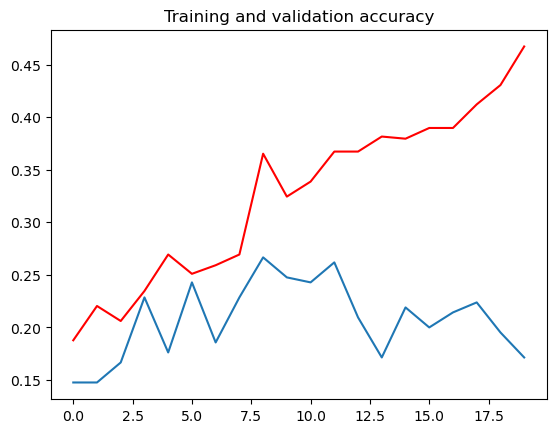

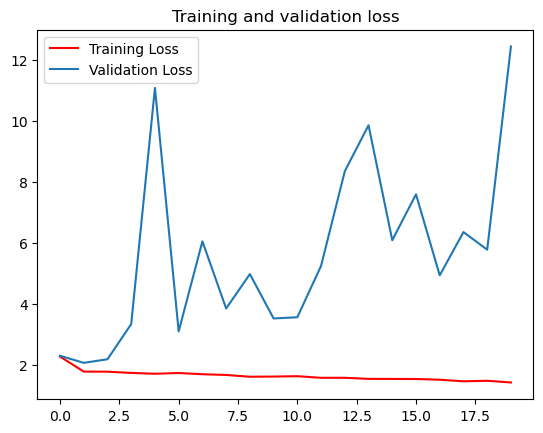

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))


plt.plot(epochs, acc, "r", label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.figure()


plt.plot(epochs, loss, "r", label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

In [25]:
(eval_loss, eval_accuracy) = model_cnn.evaluate(valid_generator, batch_size= batch_size, verbose= 1)
print('Validation Loss: ', eval_loss)
print('Validation Accuracy:', eval_accuracy)

7/7 [==============================] - 16s 2s/step - loss: 12.4322 - accuracy: 0.1714
Validation Loss:  12.432208061218262
Validation Accuracy: 0.17142857611179352


In [26]:
score = model_cnn.evaluate(test_generator, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 18.67%


In [27]:
x_test1 = x_test/255.
#test_predictions 
test_predictions=model_cnn.predict(x_test1) 

## obtention des prédictions du modèle
predictions = le.classes_[np.argmax(test_predictions, axis = 1)] # get labels and reverse back to get the text labels

# Obtenir des modalités de variable cible
target_labels1 = le.classes_[np.argmax(y_test, axis = 1)]

10/10 [==============================] - 21s 2s/step


In [28]:
predict_df2 = pd.DataFrame({"Target_labels": target_labels1, "Predictions": predictions})
predict_df2.head(20)

Target_labels                 Predictions
0           n02086240-Shih-Tzu  n02085782-Japanese_spaniel
1          n02085620-Chihuahua       n02085936-Maltese_dog
2          n02085620-Chihuahua       n02085936-Maltese_dog
3        n02085936-Maltese_dog       n02085936-Maltese_dog
4           n02086240-Shih-Tzu  n02085782-Japanese_spaniel
5           n02086240-Shih-Tzu       n02085936-Maltese_dog
6           n02086240-Shih-Tzu          n02086079-Pekinese
7        n02085936-Maltese_dog         n02085620-Chihuahua
8           n02086079-Pekinese          n02086079-Pekinese
9        n02085936-Maltese_dog  n02085782-Japanese_spaniel
10          n02086240-Shih-Tzu  n02085782-Japanese_spaniel
11  n02085782-Japanese_spaniel  n02085782-Japanese_spaniel
12          n02086240-Shih-Tzu       n02085936-Maltese_dog
13  n02085782-Japanese_spaniel       n02085936-Maltese_dog
14  n02085782-Japanese_spaniel       n02085936-Maltese_dog
15       n02085936-Maltese_dog         n02085620-Chihuahua
16          n02086079-Pekinese          n02086079-Pekinese
17         n02085620-Chihuahua       n02085936-Maltese_dog
18          n02086079-Pekinese       n02085936-Maltese_dog
19  n02085782-Japanese_spaniel  n02085782-Japanese_spaniel

In [29]:
# Précision de la mesure

correct = (target_labels1 == predictions)
accuracy = correct.sum()/correct.size
print(accuracy)

0.43


In [30]:
import random

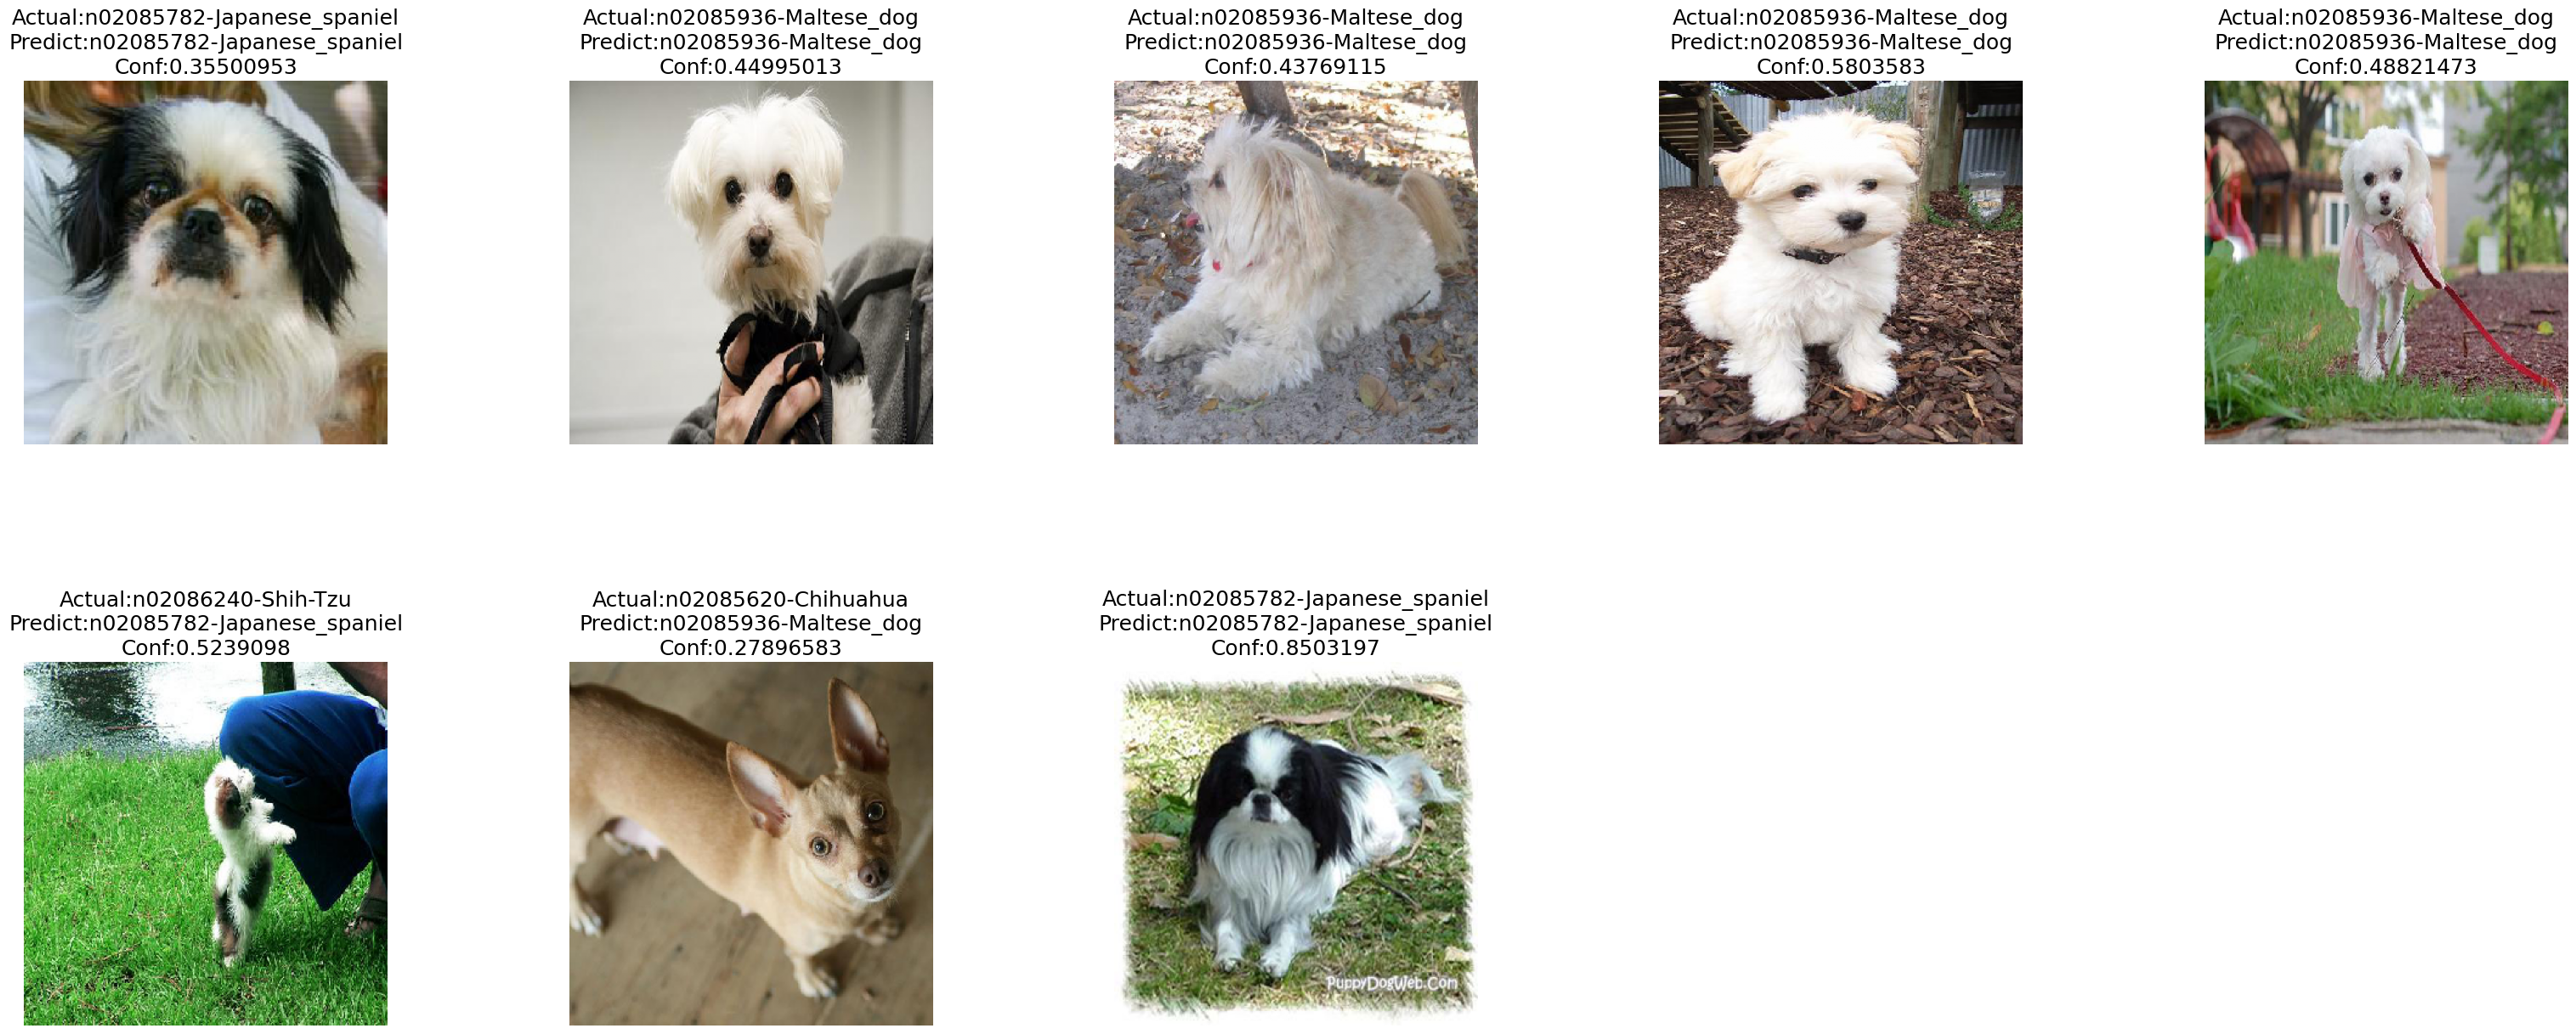

In [31]:
plt.figure(figsize = (40, 50))
for counter, i in enumerate(random.sample(range(0, len(y_test)), 8)):# random 30 images
    plt.subplot(6, 5, counter + 1)
    plt.subplots_adjust(hspace = 0.6)
    actual = str(target_labels1[i])
    predicted = str(predictions[i])
    conf = str(max(test_predictions[i]))    
    plt.imshow(x_test[i].astype(np.uint8) / 255)
    plt.axis("off")
    plt.title("Actual:" +actual+ "\nPredict:" +predicted+ "\nConf:" +conf, fontsize = 18)
    
plt.show()

## Transfert Learning inceptionV3

In [31]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers import GlobalAveragePooling2D,  Activation
from tensorflow.keras.optimizers import Adam, RMSprop

In [32]:
pre_trained_model =  InceptionV3(weights = "imagenet", input_shape=(299,299,3), include_top= False)

for layer in pre_trained_model.layers:
    layer.trainable=False

In [33]:
model = models.Sequential()
model.add(pre_trained_model)
model.add(GlobalAveragePooling2D())
model.add(Flatten()) 
model.add(Dropout(0.3))
model.add(Dense(2048, activation = 'relu'))
model.add(Dense(1024, activation = 'relu'))
model.add(Dense(512, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(len(breed_selected), activation = 'softmax'))

In [34]:
model.compile(optimizer= keras.optimizers.Adam(learning_rate=1e-3), loss ='categorical_crossentropy', metrics =['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                        

In [35]:
#plot_model(model, to_file = "model.png", show_shapes = True, show_layer_names = True)

In [ ]:
epochs = 20
start_time = time.time()

history = model.fit_generator(
    train_generator, 
    epochs = epochs,
    validation_data = valid_generator, 
    verbose = 1)
excution_time = (time.time() - start_time)/60.0
print('Training time: {:.1f}s'.format(excution_time))

/tmp/ipykernel_8030/813302040.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/20
16/16 [==============================] - 214s 13s/step - loss: 1.4453 - accuracy: 0.5980 - val_loss: 0.3770 - val_accuracy: 0.8905
Epoch 2/20
16/16 [==============================] - 196s 12s/step - loss: 0.5174 - accuracy: 0.8735 - val_loss: 0.1934 - val_accuracy: 0.9429
Epoch 3/20
16/16 [==============================] - 196s 12s/step - loss: 0.2210 - accuracy: 0.9286 - val_loss: 0.2523 - val_accuracy: 0.9238
Epoch 4/20
16/16 [==============================] - ETA: 0s - loss: 0.2058 - accuracy: 0.9245

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))


plt.plot(epochs, acc, "r", label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.figure()


plt.plot(epochs, loss, "r", label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

In [ ]:
(eval_loss, eval_accuracy) = model.evaluate(valid_generator, batch_size= batch_size, verbose= 1)
print('Validation Loss: ', eval_loss)
print('Validation Accuracy:', eval_accuracy)

In [25]:
#x_test1 = test_generator 
#test_predictions 
test_predictions=model.predict(test_generator) 

# get model predictions
predictions = le.classes_[np.argmax(test_predictions, axis = 1)] # get labels and reverse back to get the text labels

# Get target labels
target_labels = le.classes_[np.argmax(y_test, axis = 1)]

10/10 [==============================] - 93s 9s/step


IndexError: index 14 is out of bounds for axis 0 with size 6

## Stockage dans un dataframe

In [ ]:
predict_df = pd.DataFrame({"Target_labels": target_labels, "Predictions": predictions})

In [ ]:
predict_df.head(10)

## Précision de la mesure

In [ ]:
# Précision de la mesure

correct = (target_labels == predictions)
accuracy = correct.sum()/correct.size
print(accuracy)

In [ ]:
import random

In [ ]:
plt.figure(figsize = (40, 50))
for counter, i in enumerate(random.sample(range(0, len(y_test)), 30)):# random 30 images
    plt.subplot(6, 5, counter + 1)
    plt.subplots_adjust(hspace = 0.6)
    actual = str(target_labels[i])
    predicted = str(predictions[i])
    conf = str(max(test_predictions[i]))    
    plt.imshow(x_test[i].astype(np.uint8) / 255)
    plt.axis("off")
    plt.title("Actual:" + actual + "\n" + "Predict:" +predicted, color =  "red" + "\n"+ "Conf:" +conf, fontsize = 18)
    
plt.show()
     

In [ ]:
import h5py

In [ ]:
model.save("inceptionV3.h5")

In [ ]:
#model.save("inceptionV.hdf5")

## Comparaison des modèles

In [4]:
method = ["MODELE-CNN", "INCEPTION-V3"]

accuracy = [accuracy_cnn, accuracy_v3]

accuracy = [str(round(acc*100, 1))+'%' for acc in accuracy]

training_time = [round(training_time_cnn,1), round(training_timeV3,1)]

training_time_rounded = [round(tt,1) for tt in training_time]

training_time = np.array(training_time)

training_time_x = list(training_time /min(training_time))

training_time_x = [str(round(ttx,1))+'x' for ttx in training_time_x]

dict = {'Method' : method,
        'Accuracy' : accuracy,
        'Training Time [m]' : training_time_rounded,
        'Training Time [x]' : training_time_x}
df = pd.DataFrame(dict)
display(df)